<center> </center>

<center><font size=5 face="Helvetica" color=#306998><b>
MPB Tutorical: A 3D Example for Density of States 
</b></font></center>

<center><font face="Helvetica" size=3><b>Ang Chen</b></font></center>
<center><font face="Helvetica" size=3>December, 2024</font></center>

***

This notebook computes the density of states for the same example gyroid system.

This notebook imports material properties from `material.py`, integrator routines from `integrators.py`, and utility functions/classes from `util.py`, so those files must be contained in the same directory.
Please refer to those files for docstrings and citation information where applicable.

Both the tetrahedron (Tr) and Generalized Gilat-Raubenheimer (GGR) methods are used to determine the density of states.

In [1]:
from contextlib import redirect_stdout
# from functools import partial
import ase.dft.kpoints
import sys

import matplotlib.pyplot as plt
import numpy as np
from meep import mpb

sys.path.append("../../")

from pylibs.integrators import ggr_integration, tetrahedron_integration
from pylibs.material import (
    default_material,
    # eps_func,
    # gyroid_material,
    k_point_band_path,
    k_point_interpolation,
    k_point_labels,
    # k_point_sequence,
    lattice,
)
from pylibs.util import TqdmWrappedIterable, _array_to_vec3s


plt.rcParams["font.family"] = "Helvetica"
%matplotlib inline
%config InlineBackend.figure_format='svg'

Choose parameters for MPB and evaluate the bands over the k-path defined in `material.py`.

In [2]:
resolution = 16
mesh_size = 2
num_bands = 20

In [3]:
k_path_solver = mpb.ModeSolver(
    resolution=resolution,
    mesh_size=mesh_size,
    num_bands=num_bands,
    k_points=TqdmWrappedIterable(k_point_band_path),
    default_material=default_material,
    geometry_lattice=lattice,
)
k_path_solver.verbose = False

In [5]:
with open("../../data/mpb_output_band_path.txt", "w") as mpb_out, redirect_stdout(mpb_out):
    k_path_solver.run()

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Plot the band structure.

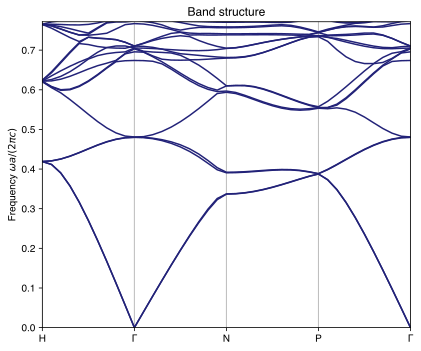

In [6]:
fig, ax = plt.subplots(figsize=(6, 5))
labels_x = np.arange(len(k_point_labels)) * k_point_interpolation
plt.xticks(ticks=labels_x, labels=k_point_labels)
for x in labels_x:
    ax.axvline(x, color="#bbb", lw=1)
for i in range(k_path_solver.all_freqs.shape[1]):
    ax.plot(k_path_solver.all_freqs[:, i], color=(34/255,34/255,120/255), lw=1.5)
ax.set_title("Band structure")
ax.set_ylabel("Frequency $\omega a/(2\pi c)$")
ax.set_ylim(0, np.max(k_path_solver.all_freqs) * .95)
ax.set_xlim(0, np.max(labels_x))
# plt.savefig("band_structure.png")
fig.tight_layout()

Determine k-points for evaluating the density of states.

In [7]:
num_points = (10, 10, 10)
for x in num_points:
    assert x % 2 == 0
k_points = _array_to_vec3s(ase.dft.kpoints.monkhorst_pack(num_points))

In [8]:
velocities = []

In [9]:
def append_velocities(solver):
    velocities.append(solver.compute_group_velocities())


def velocities_as_array():
    return np.asarray([[[v[0], v[1], v[2]] for v in band] for band in velocities])


solver = mpb.ModeSolver(
    resolution=resolution,
    mesh_size=mesh_size,
    num_bands=num_bands,
    k_points=TqdmWrappedIterable(k_points),
    default_material=default_material,
    geometry_lattice=lattice,
)
solver.verbose = False

Here, we provide `append_velocities` as a "band function." Band functions must be callables with only one argument, the `ModeSolver` instance. In an ideal world, I would prefer to use a method of a class, or even a callable class instance, but MPB does some kind of Python introspection on the provided function that prevents those approaches from working. Instead, we create a function `append_velocities` that binds a variable `velocities` from outside the function scope and appends the group velocities for each k-point as the `ModeSolver` evaluates them. Finally, we use `velocities_as_array` to convert the group velocites into a NumPy array.

See the [MPB docs](https://mpb.readthedocs.io/en/latest/Python_User_Interface/#run-functions) for additional information about running with a band function.

In [10]:
with open("../../data/mpb_output.txt", "w") as mpb_out, redirect_stdout(mpb_out):
    solver.run(append_velocities)
velocities = velocities_as_array()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

The tetrahedron integration method performs best if the tetrahedra are formed by splitting along the shortest cell diagonal. This cell arranges the frequencies in an order with the shortest diagonal.

In [11]:
reciprocal_vectors = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]])
diagonal_lengths = np.array(
    [
        np.linalg.norm(reciprocal_vectors @ [1, 1, 1]),
        np.linalg.norm(reciprocal_vectors @ [-1, 1, 1]),
        np.linalg.norm(reciprocal_vectors @ [1, -1, 1]),
        np.linalg.norm(reciprocal_vectors @ [1, 1, -1]),
    ]
)
min_diagonal_length = np.argmin(diagonal_lengths)
w_grid = solver.all_freqs.reshape(num_points + (num_bands,))
w_grid = np.flip(w_grid, axis=min_diagonal_length)

Perform the tetrahedron integration.

In [12]:
w_bins_Tr, DOS_Tr = tetrahedron_integration(
    num_points, num_bands, w_grid, w_min=0, w_max=None, num_bins=20000
)

  0%|          | 0/14580 [00:00<?, ?it/s]

Perform the Generalized Gilat-Raubenheimer integration.

In [13]:
w_bins_ggr, DOS_ggr = ggr_integration(
    num_points, solver.all_freqs, velocities, num_bins=20000
)

  0%|          | 0/20000 [00:00<?, ?it/s]

Plot the densities of states obtained from each integration method.

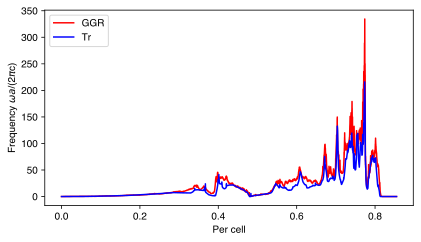

In [14]:
fig, ax = plt.subplots(figsize=(6, 3.5))
ax.plot(w_bins_ggr, DOS_ggr, 'r', label="GGR",)
ax.plot(w_bins_Tr, DOS_Tr, 'b', label="Tr")
# plt.xlim(0, 100)
ax.set_xlabel("Per cell")
ax.set_ylabel("Frequency $\omega a$/(2$\pi$c)")
ax.legend(loc=2)
# plt.savefig("density_of_states.png")
fig.tight_layout()

Plot the band structure and GGR density of states.

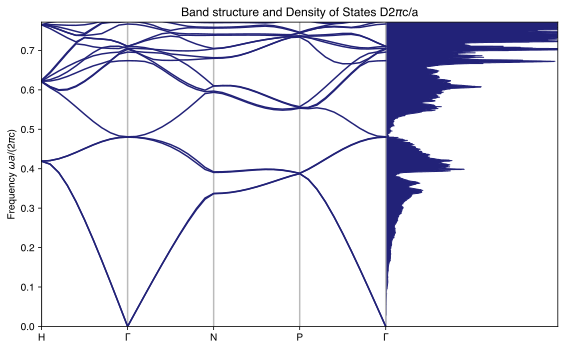

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))
labels_x = np.arange(len(k_point_labels)) * k_point_interpolation
plt.xticks(ticks=labels_x, labels=k_point_labels)
for x in labels_x:
    ax.axvline(x, color="#bbb")
for i in range(k_path_solver.all_freqs.shape[1]):
    ax.plot(k_path_solver.all_freqs[:, i], color=(34/255,34/255,120/255), lw=1.5)

x_start_dos = (len(k_point_labels) - 1) * k_point_interpolation
dos_width = 2 * k_point_interpolation / 100
fig.gca().fill_betweenx(w_bins_ggr, x_start_dos, x_start_dos + DOS_ggr * dos_width, color=(34/255,34/255,120/255))

ax.set_xlim(0, x_start_dos + dos_width * 100)
ax.set_ylim(0, np.max(k_path_solver.all_freqs) * 0.95)

ax.set_ylabel("Frequency $\omega a$/(2$\pi$c)")
ax.set_title("Band structure and Density of States D2$\pi$c/a")
# plt.savefig("band_structure_and_density_of_states.png")
fig.tight_layout()